# Importing Libraries and Resources

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error


# Importing and checking the dataset

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
df.shape

(1460, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Utility Functions

In [6]:
# Function to obtain the view of null percentage and datatype for columns with null values.

def checkNullColumns(dataframe):
    null_percentage_series = (dataframe.isnull().sum() / len(dataframe)) * 100
    null_percentage_series = null_percentage_series[null_percentage_series > 0]
    data_types = dataframe[null_percentage_series.index].dtypes
    result_df = pd.concat([null_percentage_series, data_types], axis=1)
    result_df.columns = ['Null%', 'Datatype']
    return result_df

In [7]:
def check_unique_values(dataframe, column_name):
    return dataframe[column_name].value_counts()

In [8]:
def check_for_same_values(dataframe):
    colsList = []
    for i in dataframe.columns:
        valCount = dataframe[i].value_counts();
        valCountMax = valCount.iloc[0]
        if ((valCountMax / len(dataframe[i]))*100) > 99:
            colsList.append(i)
            
    return list(colsList)

In [9]:
def getNumericFeatures(dataframe):
    numeric_variables = []
    for i in dataframe.columns:
        if dataframe[i].dtype in ['float64', 'int64']:
            numeric_variables.append(i)
    
    return numeric_variables
            

In [10]:
def getCategoricalFeatures(dataframe):
    categorical_variables = dataframe.select_dtypes(include='object').columns.tolist()
    return categorical_variables

# Data Preprocessing

### Removing all the null columns

In [11]:
# Getting a breif view of those columns who have null values in them. 

print(checkNullColumns(df))

                  Null% Datatype
LotFrontage   17.739726  float64
Alley         93.767123   object
MasVnrType     0.547945   object
MasVnrArea     0.547945  float64
BsmtQual       2.534247   object
BsmtCond       2.534247   object
BsmtExposure   2.602740   object
BsmtFinType1   2.534247   object
BsmtFinType2   2.602740   object
Electrical     0.068493   object
FireplaceQu   47.260274   object
GarageType     5.547945   object
GarageYrBlt    5.547945  float64
GarageFinish   5.547945   object
GarageQual     5.547945   object
GarageCond     5.547945   object
PoolQC        99.520548   object
Fence         80.753425   object
MiscFeature   96.301370   object


Columns `Alley`, `PoolQC`, `Fence`, and `MiscFeature` exhibit a significant percentage of null values. Therefore, these columns will be excluded from the dataset.

Also imputing in `FireplaceQu`, `LotFrontage` may create some biased results. Therefore we are dropping them.

In [12]:
df = df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'LotFrontage'], axis=1)

In [13]:
print(checkNullColumns(df))

                 Null% Datatype
MasVnrType    0.547945   object
MasVnrArea    0.547945  float64
BsmtQual      2.534247   object
BsmtCond      2.534247   object
BsmtExposure  2.602740   object
BsmtFinType1  2.534247   object
BsmtFinType2  2.602740   object
Electrical    0.068493   object
GarageType    5.547945   object
GarageYrBlt   5.547945  float64
GarageFinish  5.547945   object
GarageQual    5.547945   object
GarageCond    5.547945   object


Replacing tghe null values with `NA`, `None` or `0` respectively as per data dictionary

In [14]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')

# Replacing null values with 0 if the 'MasVnrType' is None
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)        

df['BsmtQual'] = df['BsmtQual'].fillna('NA')
df['BsmtCond'] = df['BsmtCond'].fillna('NA')
df['BsmtExposure'] = df['BsmtExposure'].fillna('NA')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NA')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NA')
df['GarageType'] = df['GarageType'].fillna('NA')
df['GarageFinish'] = df['GarageFinish'].fillna('NA')
df['GarageQual'] = df['GarageQual'].fillna('NA')
df['GarageCond'] = df['GarageCond'].fillna('NA')

# Replacing null values with 0 if the 'Garage' is not built
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)            

Checking for null clolumns again

In [15]:
print(checkNullColumns(df))

               Null% Datatype
Electrical  0.068493   object


In [16]:
# Checking unique values for column 'Electrical'

check_unique_values(df, 'Electrical')

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Since the value `SBrkr` is the mostly used value, we can replace the null values with `SBrkr` or the mode of the column `Electrical`

In [17]:
mode_Electrical = df['Electrical'].mode()[0]

df['Electrical'] = df['Electrical'].fillna(mode_Electrical)  

In [18]:
print(checkNullColumns(df))

Empty DataFrame
Columns: [Null%, Datatype]
Index: []


#### There are no columns left which are having null values.

## Removing unwanted columns

In [19]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'Enclos

In [20]:
# The column 'Id' is not needed for analysis so removing it
df = df.drop('Id', axis=1)

- Checking for Redundant columns which has same values through out the columns

In [21]:
print(check_for_same_values(df))

['Street', 'Utilities', 'PoolArea']


In [22]:
# Removing these columns as these columns are containing 99% single values
single_values_columns = check_for_same_values(df);
df = df.drop(single_values_columns, axis=1)

In [23]:
df.shape

(1460, 71)

## Standardizing values

In [24]:
df['OverallCond'] = df['OverallCond'].map({10: 'VeryExcel',9: 'Excel', 8: 'VeryGood', 7: 'Good', 6: 'AboveAvg', 5: 'Avg', 4: 'BelAvg', 3: 'Fair', 2: 'Poor', 1: 'VeryPoor'})
df['OverallQual'] = df['OverallQual'].map({10: 'VeryExcel',9: 'Excel', 8: 'VeryGood', 7: 'Good', 6: 'AboveAvg', 5: 'Avg', 4: 'BelAvg', 3: 'Fair', 2: 'Poor', 1: 'VeryPoor'})
df['MoSold'] = df['MoSold'].map({1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
df['MSSubClass'] = df['MSSubClass'].map({20: '1S_1946_NEW', 30: '1S_1945_OLD', 40: '1S_FIN_ATTIC', 45: '1.5S_UNFIN', 50: '1.5S_FIN', 60: '2S_1946_NEW', 70: '2S_1945_OLD', 75: '2.5S', 80: 'SPLIT', 85: 'SPLIT_FOYER', 90: 'DUPLEX', 120: '1S_PUD_1946_NEW', 150: '1.5S_PUD', 160: '2S_PUD_1946_NEW', 180: 'PUD_MULTILEVEL', 190: '2_FAMILY_CONV'})

# Exploratory Data Analysis

### Visualizing continuous variables

- Checking Multicollinearity

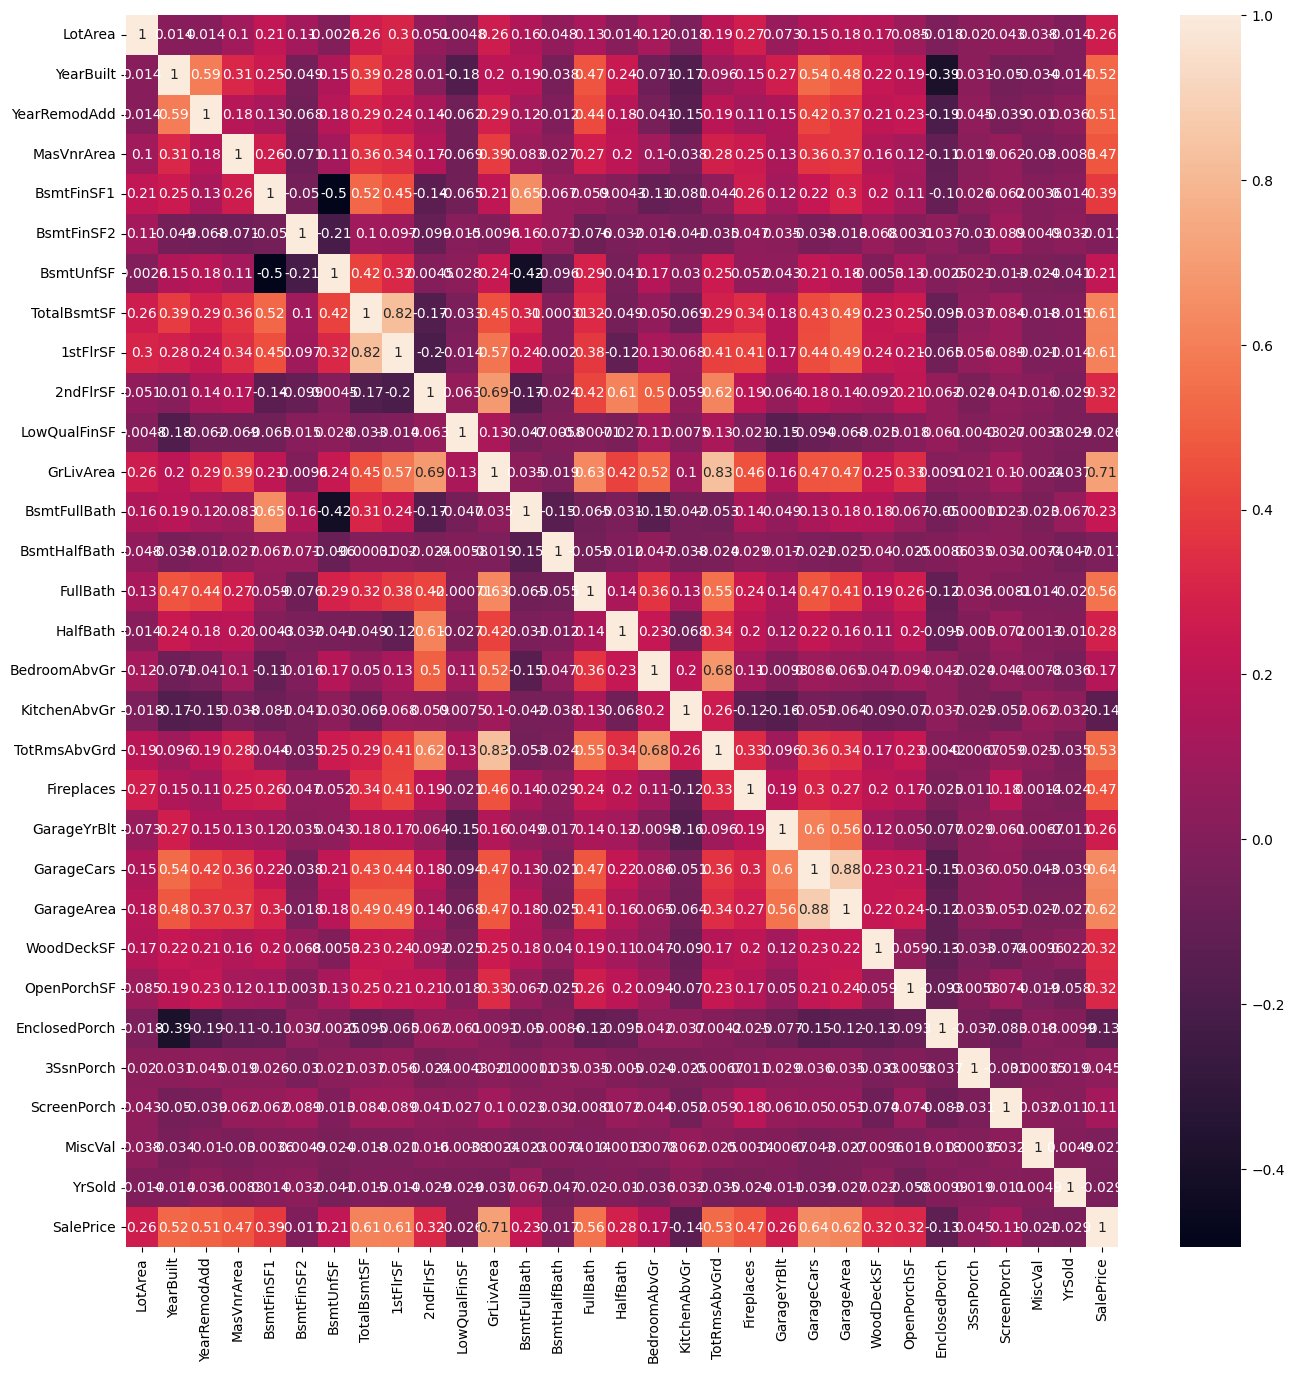

In [25]:
plt.figure(figsize=(16,16))
sns.heatmap(df[getNumericFeatures(df)].corr(),annot=True)
plt.show()

There is a collinearty between `1stFlrSF`, `TotalBsmtSF`, `GrLivArea`, `2ndFlrSF`, `TotRmsAbvGrd`, `BedroomAbvGrd`, `GarageArea`, `GarageCars`, `HalfBath`, `YearBuilt`

- Checking relation of these variables with `SalePrice`

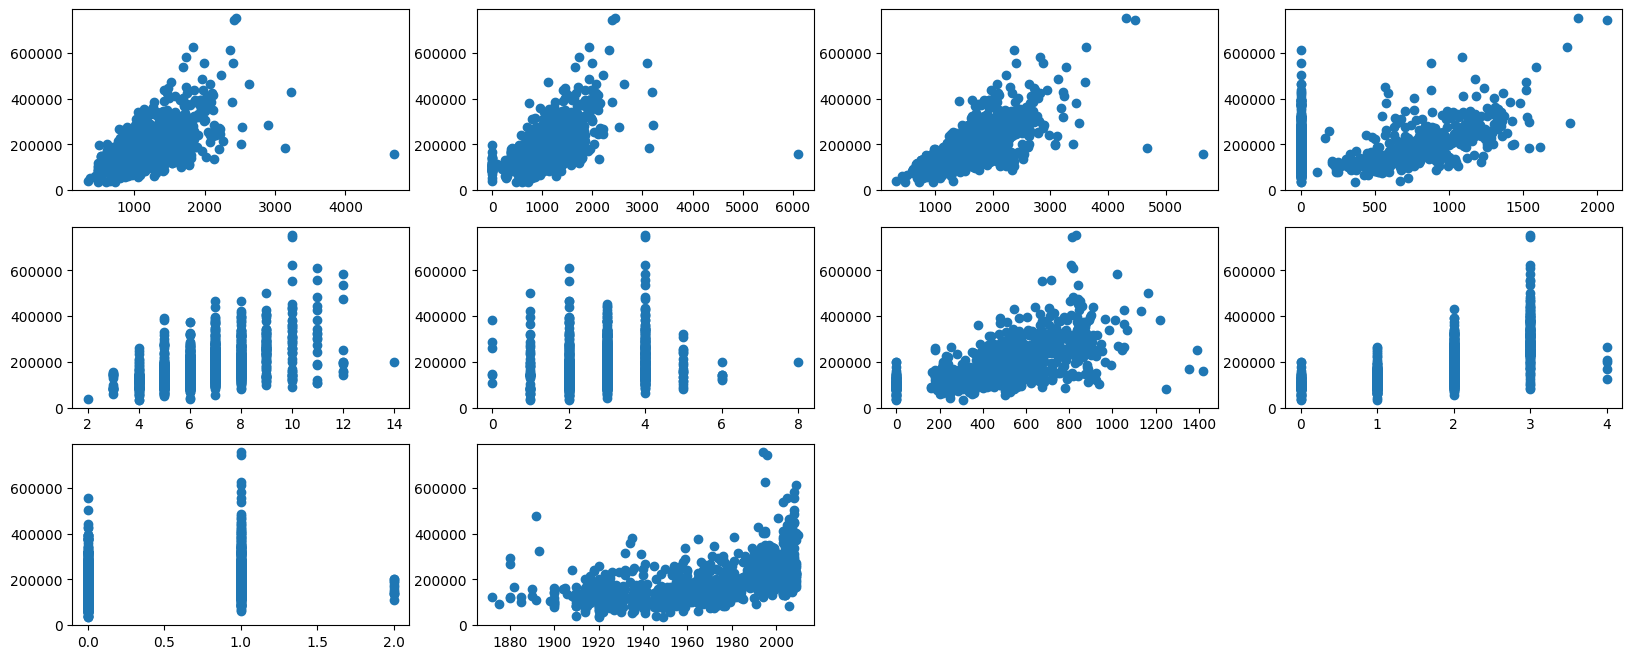

In [26]:
plt.figure(figsize=(20,8))

plt.subplot(3, 4, 1)
plt.scatter(df['1stFlrSF'],df['SalePrice'])

plt.subplot(3, 4, 2)
plt.scatter(df['TotalBsmtSF'],df['SalePrice'])

plt.subplot(3, 4, 3)
plt.scatter(df['GrLivArea'],df['SalePrice'])

plt.subplot(3, 4, 4)
plt.scatter(df['2ndFlrSF'],df['SalePrice'])

plt.subplot(3, 4, 5)
plt.scatter(df['TotRmsAbvGrd'],df['SalePrice'])

plt.subplot(3, 4, 6)
plt.scatter(df['BedroomAbvGr'],df['SalePrice'])

plt.subplot(3, 4, 7)
plt.scatter(df['GarageArea'],df['SalePrice'])

plt.subplot(3, 4, 8)
plt.scatter(df['GarageCars'],df['SalePrice'])

plt.subplot(3, 4, 9)
plt.scatter(df['HalfBath'],df['SalePrice'])

plt.subplot(3, 4, 10)
plt.scatter(df['YearBuilt'],df['SalePrice'])

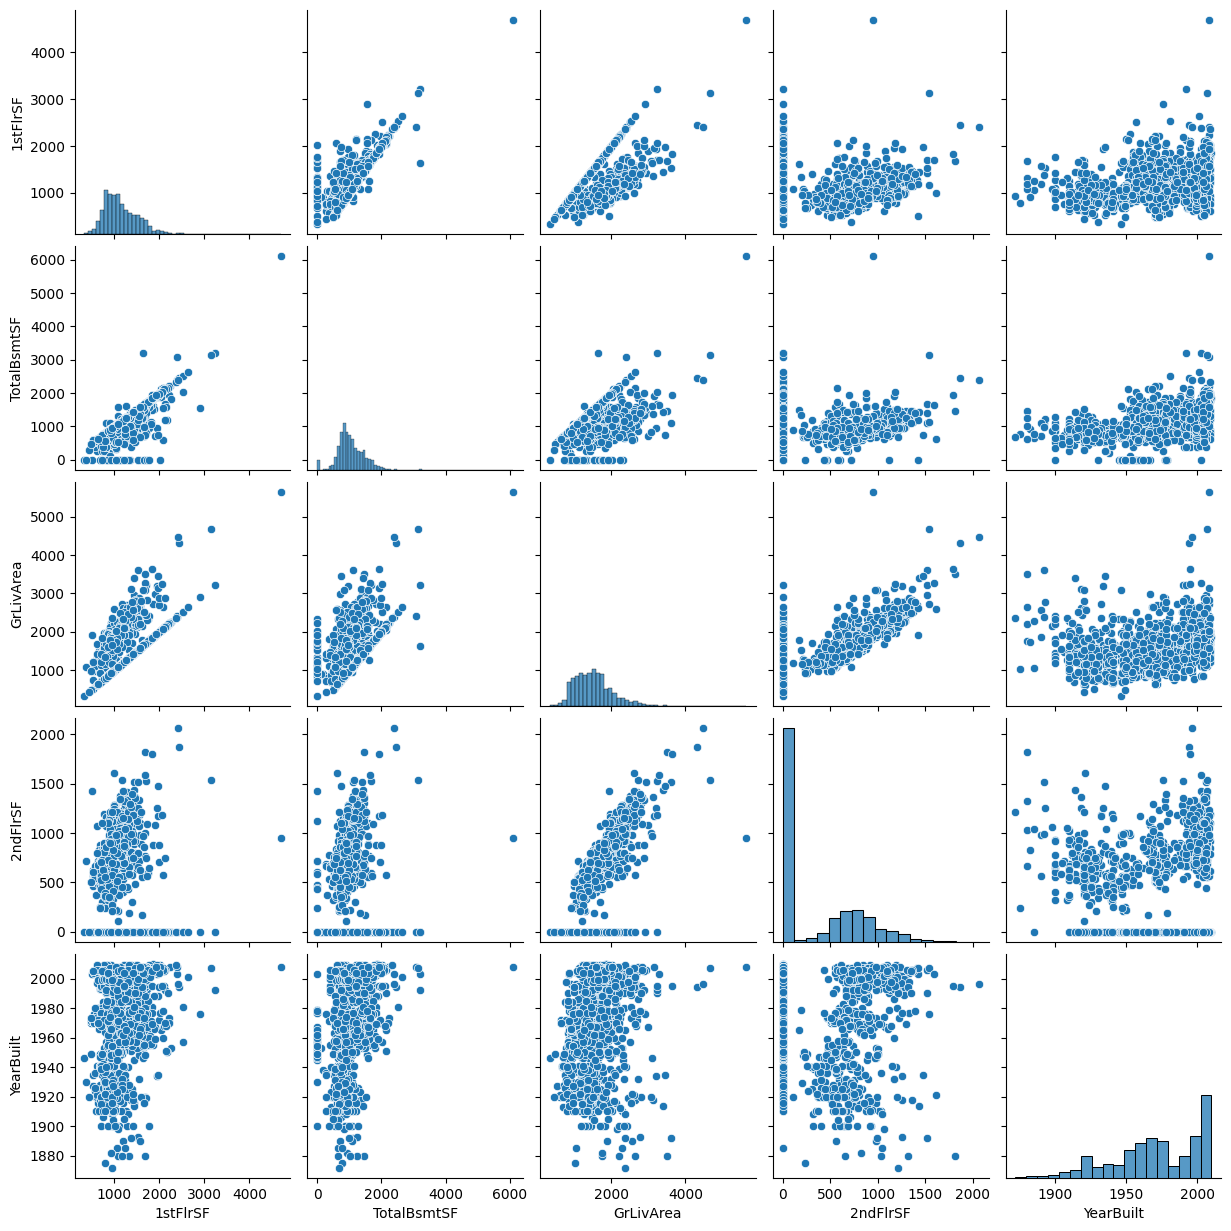

In [27]:
sns.pairplot(data=df, vars=['1stFlrSF', 'TotalBsmtSF', 'GrLivArea', '2ndFlrSF', 'YearBuilt']);

In [28]:
df['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

# Creating Dummies

In [29]:
categ_variables = getCategoricalFeatures(df)

In [30]:
numeric_variables = getNumericFeatures(df)

In [31]:
dummies_df =pd.get_dummies(df[categ_variables], drop_first=True)
df = pd.concat([df,dummies_df],axis=1)
df = df.drop(categ_variables, axis=1);

In [32]:
df.columns.tolist()

['LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'YrSold',
 'SalePrice',
 'MSSubClass_1.5S_UNFIN',
 'MSSubClass_1S_1945_OLD',
 'MSSubClass_1S_1946_NEW',
 'MSSubClass_1S_FIN_ATTIC',
 'MSSubClass_1S_PUD_1946_NEW',
 'MSSubClass_2.5S',
 'MSSubClass_2S_1945_OLD',
 'MSSubClass_2S_1946_NEW',
 'MSSubClass_2S_PUD_1946_NEW',
 'MSSubClass_2_FAMILY_CONV',
 'MSSubClass_DUPLEX',
 'MSSubClass_PUD_MULTILEVEL',
 'MSSubClass_SPLIT',
 'MSSubClass_SPLIT_FOYER',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandCon

# Splitting in train and test sets

In [33]:
df_train, df_test = train_test_split(df, train_size = 0.7, random_state = 100)

### Scaling features

In [34]:
scaler = MinMaxScaler()

In [35]:
df_train[numeric_variables] = scaler.fit_transform(df_train[numeric_variables])

In [36]:
df_test[numeric_variables] = scaler.fit_transform(df_test[numeric_variables])

In [37]:
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice']

In [38]:
X_test = df_test.drop('SalePrice', axis=1)
y_test = df_test['SalePrice']

# Regression

In [39]:
lm = LinearRegression()

In [40]:
lm.fit(X_train, y_train)

LinearRegression()

In [41]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

In [42]:
metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr)

0.9528242107804568
-1.876279389854525e+23
0.5806047537323878
1.6105396802317877e+24
0.000568662834213896
3.6686553080450746e+21


### Ridge Regression

In [43]:
ridge = Ridge()

In [44]:
# folds = KFold(n_splits=10,shuffle=True,random_state=42)
folds = 5
params = {
    'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
             4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 50.0, 100, 500, 1000]
}

In [45]:
model_cv = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring='r2',
                       cv=folds,
                       return_train_score=True,
                       verbose=1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0,
                                   50.0, 100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [46]:
alphaVal_ridge = model_cv.best_params_

In [47]:
alpha = alphaVal_ridge['alpha']

ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=7.0)

In [48]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

In [49]:
metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f'R2 for train set: {r2_train_lr}')
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f'R2 for test set: {r2_test_lr}')
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f'RSS for train set: {rss1_lr}')
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f'RSS for test set: {rss2_lr}')
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f'MSE for train set: {mse_train_lr}')
metric2.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f'MSE for test set: {mse_test_lr}')
metric2.append(mse_test_lr)

R2 for train set: 0.8950804714879854
R2 for test set: 0.8569176418083537
RSS for train set: 1.2912720279028385
RSS for test set: 1.2281743148425832
MSE for train set: 0.001264713053773593
MSE for test set: 0.002797663587340736


### Lasso regression

In [50]:
lasso = Lasso()

In [51]:
model_cv = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       scoring='r2',
                       cv=folds,
                       return_train_score=True,
                       verbose=1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0,
                                   50.0, 100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [52]:
alphaVal_lasso = model_cv.best_params_

In [53]:
alpha = alphaVal_lasso['alpha']

lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [54]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f'R2 for train set: {r2_train_lr}')
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f'R2 for test set: {r2_test_lr}')
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f'RSS for train set: {rss1_lr}')
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f'RSS for test set: {rss2_lr}')
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f'MSE for train set: {mse_train_lr}')
metric3.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f'MSE for test set: {mse_test_lr}')
metric3.append(mse_test_lr)

R2 for train set: 0.9122063696753977
R2 for test set: 0.8489480853081894
RSS for train set: 1.0804991279885476
RSS for test set: 1.2965825009942142
MSE for train set: 0.0010582753457282542
MSE for test set: 0.002953490890647413


In [55]:
lr_table = {
    'Metric':['R2 Score (Train)', 'R2 Score (Test)', 'RSS(Train)', 'RSS(Test)', 'MSE(Train)', 'MSE(Test)'],
    'Linear Regression':metric        
}

lr_metric = pd.DataFrame(lr_table, columns=['Metric', 'Linear Regression'])

rg_metric = pd.Series(metric2, name='Ridge regression')
ls_metric = pd.Series(metric3, name='Lasso regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis=1)

final_metric

,Metric,Linear Regression,Ridge regression,Lasso regression
0,R2 Score (Train),9.528242e-01,0.895080,0.912206
1,R2 Score (Test),-1.876279e+23,0.856918,0.848948
2,RSS(Train),5.806048e-01,1.291272,1.080499
3,RSS(Test),1.610540e+24,1.228174,1.296583
4,MSE(Train),5.686628e-04,0.001265,0.001058
5,MSE(Test),3.668655e+21,0.002798,0.002953


### Coefficients of regularization

In [56]:
ridge_betas = pd.DataFrame(X_train.columns)
lasso_betas = pd.DataFrame(X_train.columns)

In [57]:
ridge_betas.rows = X_train.columns
lasso_betas.rows = X_train.columns

/var/folders/_v/09g1kf1j0jb3zr1vpnlqr06m0000gn/T/ipykernel_4752/3728909147.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ridge_betas.rows = X_train.columns
/var/folders/_v/09g1kf1j0jb3zr1vpnlqr06m0000gn/T/ipykernel_4752/3728909147.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  lasso_betas.rows = X_train.columns


In [58]:
ridge_betas['Ridge'] = ridge.coef_
lasso_betas['Lasso'] = lasso.coef_

In [59]:
pd.set_option('display.max_rows', None)

ridge_betas = ridge_betas.sort_values(by='Ridge', ascending=False)
lasso_betas = lasso_betas.sort_values(by='Lasso', ascending=False)

In [60]:
ridge_betas.head(10)

,0,Ridge
116,OverallQual_VeryExcel,0.070306
9,2ndFlrSF,0.067606
11,GrLivArea,0.065233
74,Neighborhood_NoRidge,0.057508
112,OverallQual_Excel,0.056698
138,RoofMatl_WdShngl,0.048946
8,1stFlrSF,0.046719
14,FullBath,0.044359
21,GarageCars,0.039392
18,TotRmsAbvGrd,0.038222


In [61]:
lasso_betas.head(10)

,0,Lasso
11,GrLivArea,0.327001
116,OverallQual_VeryExcel,0.129553
138,RoofMatl_WdShngl,0.120152
112,OverallQual_Excel,0.091238
74,Neighborhood_NoRidge,0.054700
21,GarageCars,0.051384
117,OverallQual_VeryGood,0.043732
9,2ndFlrSF,0.043581
65,Neighborhood_Crawfor,0.035702
132,RoofMatl_CompShg,0.032560


# Conclusion

### Following are the columns which are significant in predicting price of the house

`GrLivArea` : Above grade (ground) living area square feet

`OverallQual_VeryExcel` : Very Excellent finish and overall material and finish of the house

`RoofMatl_WdShngl` : Roof material Wind shingles

`OverallQual_Excel` : Excellent finish and overall material and finish of the house

`Neighborhood_NoRidge` : NorthRidge as Neighborhood

`GarageCars` : Size of garage in car capacity

`2ndFlrSF` : Second floor square feet

### `0.0001` is the best value for Lasso Regression

### `7.0` is the best value for Ridge Regression